In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch,Rectangle
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=12) # Set x-axis tick label size
plt.rc('ytick', labelsize=12) # Set y-axis tick label size

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [2]:
root_dir='/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

In [3]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))

In [4]:
ppt_prods = ['chirps','cpc','imerg','prism',]
tws_prods = ['grace-csr','grace-jpl','clsm-grace']

In [5]:
def select(ts,m):
    if np.isnan(m):
        return np.nan
    else:
        return ts[int(m)-1]
    
out = []
for ppt_product in ppt_prods:
    for tws_product in tws_prods:
        clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county',f'{ppt_product}_{tws_product}_mon.nc'))
        clim_mon['county'] = clim_mon['county'].astype(int)
        if 'rain' not in ppt_product:
            clim_mon = clim_mon.rename({"ppt":"rain"})

        # clim_mon['rain_anom'] = clim_mon['rain'].groupby("time.month").map(lambda x: (x-x.mean('time')))
        clim_mon['tws_anom_mon'] = clim_mon['tws_def_ant'].groupby("time.month").map(lambda x: (x-x.mean('time')))
        clim_mon['tws_anom_all'] = clim_mon['tws_def_ant']-clim_mon['tws_def_ant'].mean("time")

        pexc_max_mo = clim_mon.groupby("time.year").apply(lambda g: g['p_exc'].idxmax("time").dt.month)
        tws_anom_pexcmax = xr.apply_ufunc(select,
                                          clim_mon['tws_anom_all'].groupby("time.year"),
                                          pexc_max_mo,
                                          input_core_dims=[['time'],[]],
                                          vectorize=True)
        coef = pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',f'{ppt_product}_{tws_product}','county_se','lag1.csv')).set_index('Coefficient')
        coef_ds = xr.Dataset.from_dataframe(coef.transpose())

        me_obs = coef_ds['p_exc_rxmon']+2*clim_mon['p_exc'].groupby("time.year").max()*coef_ds['p_exc_rxmon_sq']
        tws_anom_flood = tws_anom_pexcmax.where(me_obs<0)
        
        flood_count = tws_anom_flood.count(['year','index'])
        flood_count.name = 'n_flood'
        
        neg_anom_count = (tws_anom_flood<0).sum(['year','index'])
        neg_anom_count.name = 'n_flood_neg_def'
        
        merged = xr.merge([flood_count,neg_anom_count]).assign_coords(product=f'{ppt_product}_{tws_product}')
        out.append(merged)
        print(ppt_product,tws_product)
out = xr.concat(out,dim='product')
out['neg_anom_frac'] = 100*out['n_flood_neg_def']/out['n_flood']
tws_anom_frac_df = gdf.merge(out.mean('product').to_dataframe().reset_index(),on='county')

chirps grace-csr
chirps grace-jpl
chirps clsm-grace
cpc grace-csr
cpc grace-jpl
cpc clsm-grace
imerg grace-csr
imerg grace-jpl
imerg clsm-grace
prism grace-csr
prism grace-jpl
prism clsm-grace


In [6]:
delta_gdp_cnty_dict = {}
for p in ppt_prods:
    for t in tws_prods:
        with xr.open_dataset(os.path.join(project_dir,'data','processed','delta_gdp_decomposition',f'{p}_{t}.nc')) as dmg:
            dmg['delta_gdp_obs'] = dmg['pop']*dmg['delta_gdppc_obs']
            dmg = dmg.assign_coords(product=f'{p}_{t}')
            delta_gdp_cnty_dict[f'{p}_{t}'] = dmg[['delta_gdppc_obs','delta_gdp_obs']].sum('year').mean('index')

            print(p,t)
delta_gdp_cnty = xr.concat(delta_gdp_cnty_dict.values(),dim='product')


chirps grace-csr
chirps grace-jpl
chirps clsm-grace
cpc grace-csr
cpc grace-jpl
cpc clsm-grace
imerg grace-csr
imerg grace-jpl
imerg clsm-grace
prism grace-csr
prism grace-jpl
prism clsm-grace


In [7]:
delta_gdp_cnty_df = gdf.merge(delta_gdp_cnty.mean('product').to_dataframe().reset_index(),on='county')

In [8]:
delta_gdp_state_df = delta_gdp_cnty_df.groupby('state')[['delta_gdppc_obs','delta_gdp_obs']].sum()


In [9]:
delta_gdp_state_df = delta_gdp_state_df.rename(columns={"delta_gdppc_both_clim":"delta_gdppc",
                                                        "delta_gdp_both_clim":"delta_gdp"})

In [10]:
delta_gdp_state_df.to_csv(os.path.join(project_dir,'data','interim','state_damages.csv'))

In [11]:
delta_gdp_ann_dict = {}
delta_gdp_cnty_dict = {}
for p in ppt_prods:
    for t in tws_prods:
        with xr.open_dataset(os.path.join(project_dir,'data','processed','delta_gdp_decomposition',f'{p}_{t}.nc')) as dmg:
            dmg['delta_gdp_obs'] = dmg['pop']*dmg['delta_gdppc_obs']
            dmg['delta_gdp_both_clim'] = dmg['pop']*dmg['delta_gdppc_both_clim']
            dmg['delta_gdp_ppt_clim'] = dmg['pop']*dmg['delta_gdppc_ppt_clim']
            dmg['delta_gdp_tws_clim'] = dmg['pop']*dmg['delta_gdppc_tws_clim']
            dmg = dmg.assign_coords(product=f'{p}_{t}')
            delta_gdp_ann_dict[f'{p}_{t}'] = dmg[['delta_gdp_obs','delta_gdp_both_clim','delta_gdp_ppt_clim','delta_gdp_tws_clim']].sum('county')
            delta_gdp_cnty_dict[f'{p}_{t}'] = dmg[['delta_gdppc_obs','delta_gdppc_both_clim','delta_gdppc_ppt_clim','delta_gdppc_tws_clim']].sum('year').mean('index')

            print(p,t)
                             
delta_gdp_ann_all = xr.concat(delta_gdp_ann_dict.values(),dim='product').sel(year=slice(2003,2024)).cumsum("year")
delta_gdp_ann_all['ppt_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_ppt_clim']
delta_gdp_ann_all['tws_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_tws_clim']
delta_gdp_ann_all['both_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_both_clim']

delta_gdp_qs = delta_gdp_ann_all.quantile([0.025,0.5,0.975],dim=['product','index'])

delta_gdp_cnty = xr.concat(delta_gdp_cnty_dict.values(),dim='product')


chirps grace-csr
chirps grace-jpl
chirps clsm-grace
cpc grace-csr
cpc grace-jpl
cpc clsm-grace
imerg grace-csr
imerg grace-jpl
imerg clsm-grace
prism grace-csr
prism grace-jpl
prism clsm-grace


In [12]:
delta_gdp_ann_all = xr.concat(delta_gdp_ann_dict.values(),dim='product').sel(year=slice(2003,2024)).cumsum("year")
delta_gdp_ann_all['ppt_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_ppt_clim']
delta_gdp_ann_all['tws_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_tws_clim']
delta_gdp_ann_all['both_attrib'] = delta_gdp_ann_all['delta_gdp_obs']-delta_gdp_ann_all['delta_gdp_both_clim']

delta_gdp_qs = delta_gdp_ann_all.drop_sel(product='cpc_grace-jpl').quantile([0.025,0.5,0.975],dim=['product','index'])

delta_gdp_cnty = xr.concat(delta_gdp_cnty_dict.values(),dim='product').drop_sel(product='cpc_grace-jpl')


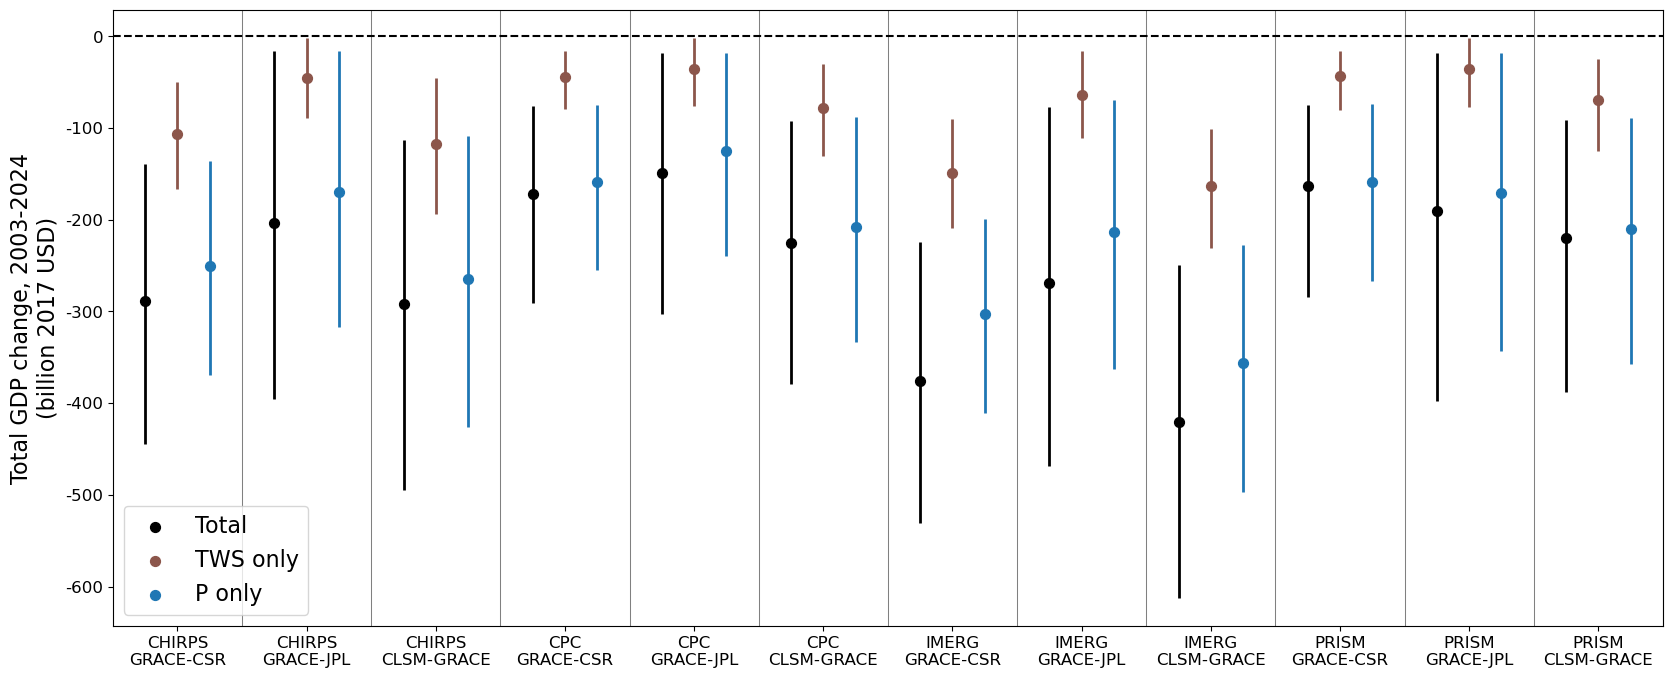

In [13]:
fig,ax = plt.subplots(figsize=(20,8))
i=0
for p,ds in delta_gdp_ann_dict.items():
    ds['ppt_attrib'] = ds['delta_gdp_obs']-ds['delta_gdp_ppt_clim']
    ds['tws_attrib'] = ds['delta_gdp_obs']-ds['delta_gdp_tws_clim']
    ds['both_attrib'] = ds['delta_gdp_obs']-ds['delta_gdp_both_clim']

    ax.scatter([i-1/4],[ds['both_attrib'].sum('year').mean()],s=50,color='black',label='Total')
    ax.vlines(i-1/4,ds['both_attrib'].sum('year').quantile(0.025,'index'),ds['both_attrib'].sum('year').quantile(0.975,'index'),color='black',lw=2)
    ax.scatter([i],[ds['tws_attrib'].sum('year').mean()],s=50,color='tab:brown',label='TWS only')
    ax.vlines(i,ds['tws_attrib'].sum('year').quantile(0.025,'index'),ds['tws_attrib'].sum('year').quantile(0.975,'index'),color='tab:brown',lw=2)
    ax.scatter([i+1/4],[ds['ppt_attrib'].sum('year').mean()],s=50,color='tab:blue',label='P only')
    ax.vlines(i+1/4,ds['ppt_attrib'].sum('year').quantile(0.025,'index'),ds['ppt_attrib'].sum('year').quantile(0.975,'index'),color='tab:blue',lw=2)
    ax.axvline(i+1/2,color='grey',lw=0.75)
    if i==0:
        ax.legend()
    i+=1
ax.set_xlim(-1/2,11.5)
ax.set_xticks(np.arange(12))
ax.axhline(0,color='black',linestyle='--')
labels = []
for p in delta_gdp_ann_dict.keys():
    ppt_prod,tws_clim_prod=p.split("_")
    labels.append(f'{ppt_prod.upper()}\n{tws_clim_prod.upper()}')
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(-6e11,1,1e11))
ax.set_yticklabels(np.arange(-600,1,100))
ax.set_ylabel("Total GDP change, 2003-2024\n(billion 2017 USD)")
plt.savefig(os.path.join(project_dir,'figures','supp_mat','agg_dmg_obs_uncert.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','agg_dmg_obs_uncert.pdf'),bbox_inches='tight',dpi=350)
plt.show()

In [14]:
delta_gdp_df = gdf.merge(delta_gdp_cnty.mean("product").to_dataframe().reset_index(),on='county')
delta_gdp_df['tws_frac_gdppc'] = 100*delta_gdp_df['delta_gdppc_ppt_clim']/delta_gdp_df['delta_gdppc_obs']
delta_gdp_df['ppt_frac_gdppc'] = 100*delta_gdp_df['delta_gdppc_tws_clim']/delta_gdp_df['delta_gdppc_obs']

delta_gdp_df['log_delta_gdppc'] = np.sign(delta_gdp_df['delta_gdppc_obs'])*np.log10(np.abs(delta_gdp_df['delta_gdppc_obs']))
delta_gdp_df.loc[~np.isfinite(delta_gdp_df['log_delta_gdppc']),'log_delta_gdppc'] = np.nan

In [15]:
delta_gdp_df['tws_frac_gdppc'].median()

19.967958378052987

In [16]:
tws_levels = np.arange(50,101,5)
tws_cols = sns.color_palette("YlGnBu",len(tws_levels))
tws_cmap = mpl.colors.ListedColormap(tws_cols[1:])
tws_cmap.set_under(tws_cols[0])
tws_norm = plt.Normalize(vmin=50,vmax=100)

frac_levels = np.arange(0,101,5)
frac_cols = sns.color_palette("BrBG_r",len(frac_levels)+1)
frac_cmap = mpl.colors.ListedColormap(frac_cols[1:-1])
frac_cmap.set_under(frac_cols[0])
frac_cmap.set_over(frac_cols[-1])
frac_norm = plt.Normalize(vmin=0,vmax=100)

dmg_levels = np.arange(-3e3,1,250)
dmg_cols = sns.color_palette("YlOrRd_r",len(dmg_levels)+3)
dmg_cmap = mpl.colors.ListedColormap(dmg_cols[1:-3])
dmg_cmap.set_under(dmg_cols[0])
dmg_cmap.set_over('tab:grey')
dmg_norm = plt.Normalize(vmin=-3e3,vmax=0)

In [17]:
gdf_state = gdf.dissolve(by='state')

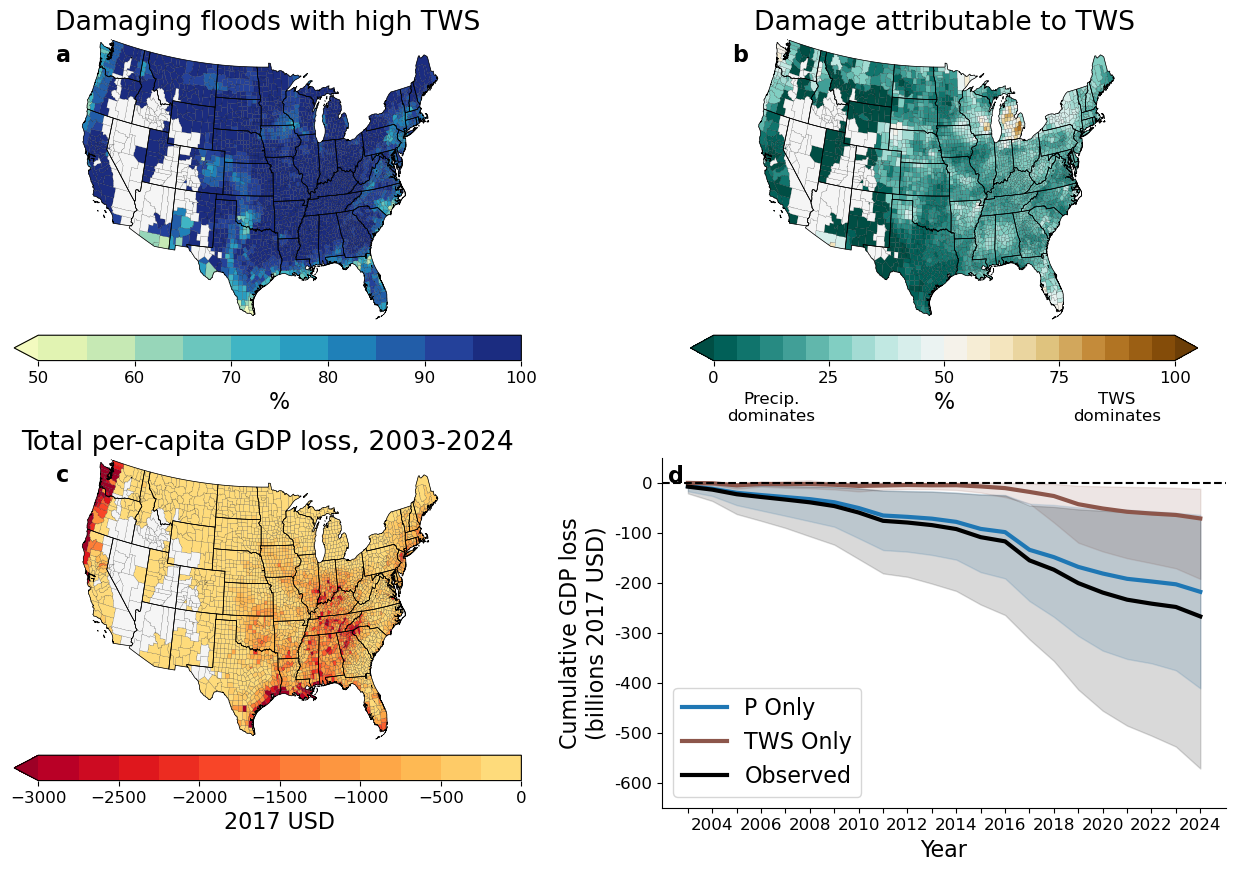

In [18]:
import seaborn as sns

no_dmg_cntys = delta_gdp_df[delta_gdp_df.delta_gdppc_obs>=0]['county']

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(nrows=2,ncols=2,figure=fig)

ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
tws_anom_frac_df[~tws_anom_frac_df['county'].isin(no_dmg_cntys)].plot(ax=ax1,transform=ccrs.PlateCarree(),column='neg_anom_frac',cmap=tws_cmap,norm=tws_norm,edgecolor='black',lw=0.1)
tws_anom_frac_df[tws_anom_frac_df['county'].isin(no_dmg_cntys)].plot(ax=ax1,transform=ccrs.PlateCarree(),color='whitesmoke',edgecolor='black',lw=0.1)
ax1.title.set_text("Damaging floods with high TWS")
tws_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=tws_norm,cmap=tws_cmap),ax=ax1,orientation='horizontal',ticks=np.arange(50,101,10),extend='min',shrink=0.9,pad=0)
tws_cbar.ax.set_xlabel('%')

ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
delta_gdp_df[~delta_gdp_df['county'].isin(no_dmg_cntys)].plot(ax=ax2,column='tws_frac_gdppc',cmap=frac_cmap,norm=frac_norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
delta_gdp_df[delta_gdp_df['county'].isin(no_dmg_cntys)].plot(ax=ax2,color='whitesmoke',transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax2.title.set_text("Damage attributable to TWS")
frac_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=frac_norm,cmap=frac_cmap),ax=ax2,orientation='horizontal',ticks=np.arange(0,101,25),extend='both',shrink=0.9,pad=0)
frac_cbar.ax.set_xlabel('%')
frac_cbar.ax.text(0.125,-1.2,'Precip.\ndominates',ha='center',va='top',transform=frac_cbar.ax.transAxes,fontsize=12)
frac_cbar.ax.text(0.875,-1.2,'TWS\ndominates',ha='center',va='top',transform=frac_cbar.ax.transAxes,fontsize=12)

ax3 = plt.subplot(gs[1,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
delta_gdp_df[~delta_gdp_df['county'].isin(no_dmg_cntys)].plot(ax=ax3,transform=ccrs.PlateCarree(),column='delta_gdppc_obs',cmap=dmg_cmap,norm=dmg_norm,edgecolor='black',lw=0.1)
delta_gdp_df[delta_gdp_df['county'].isin(no_dmg_cntys)].plot(ax=ax3,transform=ccrs.PlateCarree(),color='whitesmoke',edgecolor='black',lw=0.1)
ax3.title.set_text("Total per-capita GDP loss, 2003-2024")
dmg_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=dmg_norm,cmap=dmg_cmap),ax=ax3,orientation='horizontal',extend='min',shrink=0.9,pad=0)
dmg_cbar.ax.set_xlabel('2017 USD')

for ax in [ax1,ax2,ax3]:
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    ax.set_frame_on(False)
    gdf_state.geometry.boundary.plot(ax=ax,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.5)

    # ax.add_feature(cartopy.feature.STATES,edgecolor='black',lw=0.5)

ax4 = plt.subplot(gs[1,1])
yrs = np.arange(2003,2025)
ax4.plot(yrs,delta_gdp_qs['ppt_attrib'].sel(quantile=0.5),color='tab:blue',lw=3,label='P Only')
ax4.fill_between(yrs,delta_gdp_qs['ppt_attrib'].sel(quantile=0.025),delta_gdp_qs['ppt_attrib'].sel(quantile=0.975),color='tab:blue',alpha=0.15)
ax4.plot(yrs,delta_gdp_qs['tws_attrib'].sel(quantile=0.5),color='tab:brown',lw=3,label='TWS Only')
ax4.fill_between(yrs,delta_gdp_qs['tws_attrib'].sel(quantile=0.025),delta_gdp_qs['tws_attrib'].sel(quantile=0.975),color='tab:brown',alpha=0.15)
ax4.plot(yrs,delta_gdp_qs['delta_gdp_obs'].sel(quantile=0.5),color='black',lw=3,label='Observed')
ax4.fill_between(yrs,delta_gdp_qs['delta_gdp_obs'].sel(quantile=0.025),delta_gdp_qs['delta_gdp_obs'].sel(quantile=0.975),color='black',alpha=0.15)
# ax4.plot(yrs,noflood_dmg_ann['delta_gdp'].sel(quantile=0.5),color='black',lw=3,label='Total')
ax4.set_xticks(yrs)
for l in ax4.get_xticklabels()[::2]:
    l.set_visible(False)
ax4.set_xlabel("Year")
ax4.set_ylabel("Cumulative GDP loss\n(billions 2017 USD)")
ax4.legend(loc='lower left',)
ax4.axhline(0,color='black',linestyle='--')
ax4.set_yticks(np.arange(-6e11,1,1e11))
ax4.set_yticklabels(np.arange(-600,1,100))
ax4.set_ylim(-6.5e11,5e10)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)


labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4,]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
plt.savefig(os.path.join(project_dir,'figures','main','fig3_aggregate.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','main','fig3_aggregate.pdf'),bbox_inches='tight',dpi=350)
plt.show()

In [19]:
(delta_gdp_ann_all['ppt_attrib'].isel(year=-1)/delta_gdp_ann_all['delta_gdp_obs'].isel(year=-1)).quantile([0.025,0.975])

<xarray.DataArray (quantile: 2)> Size: 16B
array([0.59894277, 0.98353769])
Coordinates:
  * quantile  (quantile) float64 16B 0.025 0.975

In [20]:
delta_gdp_qs['ppt_attrib'].isel(year=-1)/delta_gdp_qs['delta_gdp_obs'].isel(year=-1)

<xarray.DataArray (quantile: 3)> Size: 24B
array([0.71947957, 0.8160212 , 0.92818626])
Coordinates:
  * quantile  (quantile) float64 24B 0.025 0.5 0.975

In [21]:
delta_gdp_qs['ppt_attrib'].isel(year=-1)/delta_gdp_qs['delta_gdp_obs'].isel(year=-1)

<xarray.DataArray (quantile: 3)> Size: 24B
array([0.71947957, 0.8160212 , 0.92818626])
Coordinates:
  * quantile  (quantile) float64 24B 0.025 0.5 0.975

In [24]:
delta_gdp_qs['delta_gdp_obs'].isel(year=-1)

<xarray.DataArray 'delta_gdp_obs' (quantile: 3)> Size: 24B
array([-5.71567624e+11, -2.67381467e+11, -6.91720276e+10])
Coordinates:
  * quantile  (quantile) float64 24B 0.025 0.5 0.975